# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [4]:
# !pip install pycrf
# !pip install sklearn-crfsuite

#Importing the required libraries
import spacy
import sklearn_crfsuite
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk import FreqDist
from sklearn_crfsuite import metrics
  
model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


In [6]:
## Load each file and preprocess sentences in each file to generate sentences list 
def preprocess_input(input_file):
    input_file_object = open(input_file, 'r')
    input_data = input_file_object.readlines()
    input_file_object.close()
    
    sentence_list = []
    sentence = ""

    for word in input_data:
        word = word.strip() # removing any space
        if word == "":
            sentence_list.append(sentence) # To append the final sentence list
            sentence = ""
        else:
            if sentence:
                sentence = sentence + " " + word
            else:
                sentence = word
                
    return sentence_list

### Construct the proper sentences from individual words and print the 5 sentences.

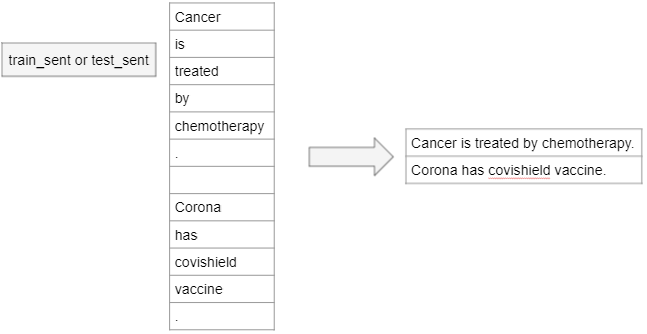

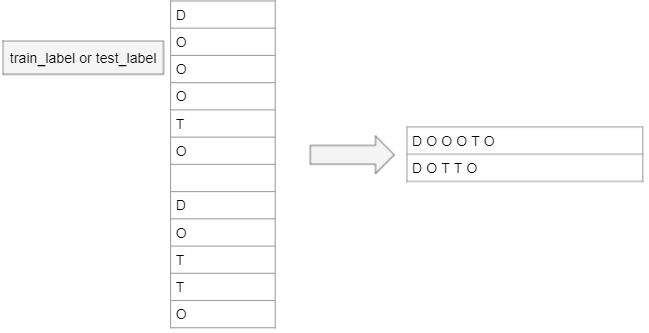

In [9]:
train_sent = preprocess_input('train_sent')
train_label = preprocess_input('train_label')
test_sent = preprocess_input('test_sent')
test_label = preprocess_input('test_label')

In [10]:
def print_sent(sents, label, count=5):
    for i in range(count):
        print("Sentence", i, " : ", sents[i])
        
        display(pd.DataFrame([sents[i].split(), label[i].split()], columns = np.arange(len(sents[i].split())), index = ["sentences", "label"]))

In [11]:
input_train_label_file_object = open("train_label", 'r')
input_train_label_data = input_train_label_file_object.readlines()
input_train_label_file_object.close()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25156\3781411630.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


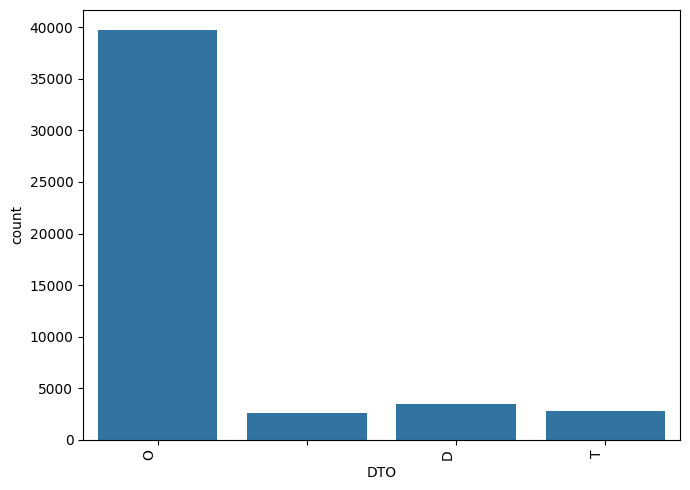

In [12]:
#Words distribution across DTO in train label
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='DTO', data=pd.DataFrame(input_train_label_data, columns=["DTO"]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [13]:
input_test_label_file_object = open("test_label", 'r')
input_test_label_data = input_test_label_file_object.readlines()
input_test_label_file_object.close()

C:\Users\Admin\AppData\Local\Temp\ipykernel_25156\1426915616.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


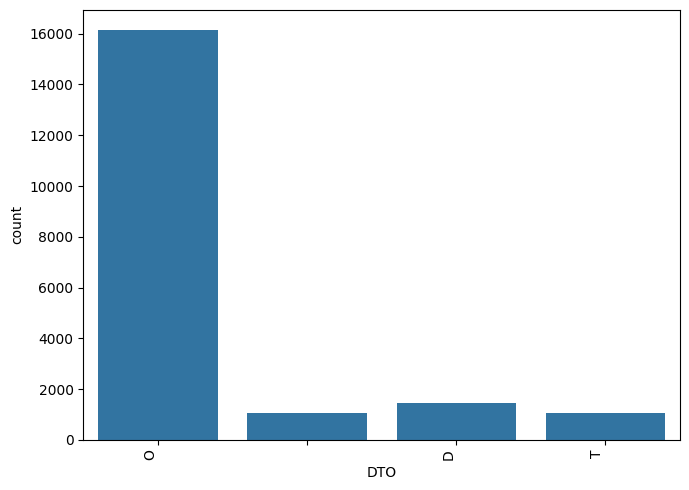

In [14]:
#Words distribution across DTO in test label
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='DTO', data=pd.DataFrame(input_test_label_data, columns=["DTO"]), orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [15]:
print_sent(train_sent, train_label, count=5)

Sentence 0  :  All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
sentences,All,live,births,>,or,=,23,weeks,at,the,...,",",and,practice,group,(,to,reflect,risk,status,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 1  :  The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
sentences,The,total,cesarean,rate,was,14.4,%,(,344,of,...,primary,rate,was,11.4,%,(,244,of,2144,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 2  :  Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
sentences,Abnormal,presentation,was,the,most,common,indication,(,25.6,%,",",88,of,344,)
label,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


Sentence 3  :  The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
sentences,The,``,corrected,'',cesarean,rate,(,maternal-fetal,medicine,and,...,primary,rate,was,9.6,%,(,190,of,1975,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 4  :  Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
sentences,Arrest,of,dilation,was,the,most,common,indication,in,both,...,'',subgroups,(,23.4,and,24.6,%,",",respectively,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


In [16]:
print_sent(test_sent, test_label, count=5)

Sentence 0  :  Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )


,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
sentences,Furthermore,",",when,all,deliveries,were,analyzed,",",regardless,of,...,2214,;,primary,9.2,%,",",183,of,1994,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 1  :  As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
sentences,As,the,ambient,temperature,increases,",",there,is,an,increase,in,insensible,fluid,loss,and,the,potential,for,dehydration
label,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


Sentence 2  :  The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
sentences,The,daily,high,temperature,ranged,from,71,to,104,degrees,...,ranged,from,1.7,to,24.7,cm,during,the,study,period
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 3  :  There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
sentences,There,was,a,significant,correlation,between,the,2-,",",3-,...,=,0.31,",",p,&,#,60,;,0.001,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 4  :  Fluctuations in ambient temperature are inversely correlated to changes in AFI


,0,1,2,3,4,5,6,7,8,9,10
sentences,Fluctuations,in,ambient,temperature,are,inversely,correlated,to,changes,in,AFI
label,O,O,O,O,O,O,O,O,O,O,O


### Count the number of sentences in the processed train and test dataset 

In [18]:
print("No. sentences in processed train dataset is: ", len(train_sent))
print("No. sentences in processed test dataset is: ", len(test_sent))

No. sentences in processed train dataset is:  2599
No. sentences in processed test dataset is:  1056


### Count the number of lines of labels in the processed train and test dataset.

In [20]:
print("No. sentences in processed train dataset is: ", len(train_label))
print("No. sentences in processed test dataset is: ", len(test_label))

No. sentences in processed train dataset is:  2599
No. sentences in processed test dataset is:  1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [23]:
all_noun_propn = []
all_sentence = train_sent + test_sent

for sentence in all_sentence:
    doc = model(sentence)
    
    for token in doc:
        if token.pos_=="NOUN" or token.pos_ == "PROPN":
            all_noun_propn.append(token.text)

In [24]:
len(all_noun_propn)

24371

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [26]:
word_frequency = FreqDist(all_noun_propn)
pd.DataFrame(word_frequency.most_common(25), columns=["Sentence", "Count"])

,Sentence,Count
0,patients,492
1,treatment,281
2,%,247
3,cancer,200
4,therapy,175
5,study,153
6,disease,141
7,cell,140
8,lung,116
9,group,94


## Defining features for CRF





In [28]:
# Let's define the features to get the feature value for one word.

def generateFeaturesForOneWord(sentence, pos):
    word = sentence[pos]

    features = [
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=' + str(word.isupper()),
        'word.isdigit=' + str(word.isdigit()),
        'word.startsWithCapital=' + str(word[0].isupper())
    ]

    if pos > 0:
        prev_word = sentence[pos - 1]
        features.extend([
            'prev_word.lower=' + prev_word.lower(),
            'prev_word.isupper=' + str(prev_word.isupper()),
            'prev_word.isdigit=' + str(prev_word.isdigit()),
            'prev_word.startsWithCapital=' + str(prev_word[0].isupper())
        ])

    else:
        features.append('BEG')

    if pos == len(sentence) - 1:
        features.append('END')

    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [31]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    sentence_list = sentence.split()
    return [generateFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

In [32]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence 
example_sentence = train_sent[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'BEG']

### Write a code/function to get the labels of a sentence

In [34]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [38]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [40]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

## Build the CRF Model

In [42]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [43]:
repr(crf)
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [46]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [48]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9042560946986944


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

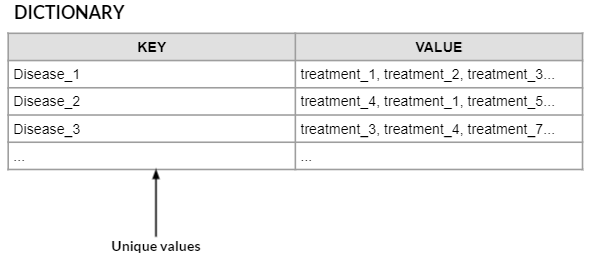

In [52]:
df_disease_n_treatment = pd.DataFrame([], columns=["Disease", "Treatments"])
df_disease_n_treatment

,Disease,Treatments


In [53]:
for i in range(len(y_pred)):
        p_val = y_pred[i]
        disease = ""
        treatmemt = ""
        
        DTO = set(p_val)
        if "D" in DTO and "T" in DTO:
            for j in range(len(p_val)):
                if p_val[j] == 'D':
                    disease += test_sent[i].split()[j] + " "
                elif p_val[j] == 'T':
                    treatmemt += test_sent[i].split()[j] + " "
        
            disease = disease.strip()
            treatmemt = treatmemt.strip()
        
            present = df_disease_n_treatment.loc[(df_disease_n_treatment.Disease == disease), ["Disease"]]
            if present.size:
                df_treatment = df_disease_n_treatment.loc[(df_disease_n_treatment.Disease == disease), ["Treatments"]]
                treatments_list = df_treatment.values.tolist()
                treatments_list.extend([treatmemt])
                df_disease_n_treatment.loc[(df_disease_n_treatment.Disease == disease), ["Treatments"]] = [[treatments_list]]
            
            else:
                df_disease_n_treatment = pd.concat([df_disease_n_treatment, pd.DataFrame([[disease, treatmemt]], columns=df_disease_n_treatment.columns )])
        
df_disease_n_treatment = df_disease_n_treatment.set_index(np.arange(df_disease_n_treatment.shape[0]))

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [55]:
disease = 'hereditary retinoblastoma'
df_disease_n_treatment.loc[(df_disease_n_treatment.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


## Develop Generic Functions to build & evaluate CRF models with various options 

In [57]:
# Let's define the features to get the feature value for one word.

def generateFeaturesForOneWord(sentence, pos, pos_tags, deptags=None):
    word = sentence[pos]

    features = [
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=' + str(word.isupper()),
        'word.isdigit=' + str(word.isdigit()),
        'word.startsWithCapital=' + str(word[0].isupper()),
        'word.pos=' + str(pos_tags[pos])
    ]

    if deptags is not None:
        features.extend('word.dep_=' + str(deptags[pos]))

    if pos > 0:
        prev_word = sentence[pos - 1]
        features.extend([
            'prev_word.lower=' + prev_word.lower(),
            'prev_word.isupper=' + str(prev_word.isupper()),
            'prev_word.isdigit=' + str(prev_word.isdigit()),
            'prev_word.startsWithCapital=' + str(prev_word[0].isupper()),
            'prev_word.pos=' + str(pos_tags[pos - 1])
        ])

        if deptags is not None:
            features.extend('prev_word.dep_=' + str(deptags[pos - 1]))
    else:
        features.append('BEG')

    if pos == len(sentence) - 1:
        features.append('END')

    return features


In [58]:
# Function to get features for a sentence.
def generateFeaturesForOneSentence(sentence, dependency_tag):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    pos_tags = []
    dep_tags = []
    
    for each_token in processed_sent:
        pos_tags.append(each_token.pos_)
        dep_tags.append(each_token.dep_) # add dep
    
    sentence_list = sentence.split()
    if dependency_tag:
        features_for_one_sentence = [generateFeaturesForOneWord(sentence_list, pos, pos_tags, dep_tags) for pos in range(len(sentence_list))]
    else:
        features_for_one_sentence = [generateFeaturesForOneWord(sentence_list, pos, pos_tags) for pos in range(len(sentence_list))]
    
    return features_for_one_sentence

In [59]:
# Write a code to get the labels for a sentence.
def generateLabelsInListForOneSentence(labels):
    return labels.split()

In [60]:
def convert_feature_lists_to_clean_dicts(X):
    converted = []
    for sent in X:
        new_sent = []
        for token_features in sent:
            feature_dict = {}
            for feature in token_features:
                if '=' in feature:
                    key, value = feature.split('=', 1)
                    feature_dict[str(key).strip()] = str(value).strip()
                else:
                    feature_dict[str(feature).strip()] = 'True'
            new_sent.append(feature_dict)
        converted.append(new_sent)
    return converted


In [61]:
def build_generic_crf_model(train_sent, test_sent, train_label, test_label, dependency_tag, max_iterations=100):
    
    X_train = [generateFeaturesForOneSentence(sentence, dependency_tag) for sentence in train_sent]
    X_test = [generateFeaturesForOneSentence(sentence, dependency_tag) for sentence in test_sent]

    y_train = [generateLabelsInListForOneSentence(label) for label in train_label]
    y_test = [generateLabelsInListForOneSentence(label) for label in test_label]


    # Build the CRF model.
    crf_model = sklearn_crfsuite.CRF(
        algorithm='lbfgs',          
        max_iterations=max_iterations,
        all_possible_transitions=True
    )

    
    # Fit the model with train & test data
    crf_model.fit(X_train, y_train)

    return crf_model, X_test, y_test
    

In [62]:
def evaludate_crf_model(crf_model, X_test, y_test):
   
    ##Evaluation
    
    ### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.
    y_pred = crf_model.predict(X_test)

    ### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.
    f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
    
    return y_pred, f1_score
    

In [63]:
### Creating Dataframe for Disease and Treatments
def build_disease_treatment_dataset(y_pred,test_sent):
    df_disease_n_treatment = pd.DataFrame([], columns=["Disease", "Treatments"])
    for i in range(len(y_pred)):
        p_val = y_pred[i]
        disease = ""
        treatmemt = ""
        
        DTO = set(p_val)
        if "D" in DTO and "T" in DTO:
            for j in range(len(p_val)):
                if p_val[j] == 'D':
                    disease += test_sent[i].split()[j] + " "
                elif p_val[j] == 'T':
                    treatmemt += test_sent[i].split()[j] + " "
        
            disease = disease.strip()
            treatmemt = treatmemt.strip()
        
            present = df_disease_n_treatment.loc[(df_disease_n_treatment.Disease == disease), ["Disease"]]
            if present.size:
                df_treatment = df_disease_n_treatment.loc[(df_disease_n_treatment.Disease == disease), ["Treatments"]]
                treatments_list = df_treatment.values.tolist()
                treatments_list.extend([treatmemt])
                df_disease_n_treatment.loc[(df_disease_n_treatment.Disease == disease), ["Treatments"]] = [[treatments_list]]
            
            else:
                df_disease_n_treatment = pd.concat([df_disease_n_treatment, pd.DataFrame([[disease, treatmemt]], columns=df_disease_n_treatment.columns )])
        
    df_disease_n_treatment = df_disease_n_treatment.set_index(np.arange(df_disease_n_treatment.shape[0]))
    return df_disease_n_treatment

### Model 2: Adding POS tag in feature

#### Build the CRF Model with POS tag

In [66]:
crf_model, X_test, y_test  = build_generic_crf_model(train_sent, test_sent, train_label, test_label, 0)

#### Generate the F1 score for CRF model build with POS Tag

In [68]:
y_pred, f1_score = evaludate_crf_model(crf_model, X_test, y_test)
print("F1 Score: ",f1_score)

F1 Score:  0.9060925340592906


#### Generate the Disease & Treatment dataset

In [70]:
df_disease_treatment = build_disease_treatment_dataset(y_pred, test_sent)

#### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [72]:
disease = 'hereditary retinoblastoma'
df_disease_treatment.loc[(df_disease_treatment.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


### Model 3: Adding POS tag and Dependancy tag in feature

#### Build the CRF Model with POS & Dependency tag

In [75]:
crf_model, X_test, y_test  = build_generic_crf_model(train_sent, test_sent, train_label, test_label, 1)

#### Generate the F1 score for CRF model build with POS Tag & Dependency tag

In [77]:
y_pred, f1_score = evaludate_crf_model(crf_model, X_test, y_test)
print("F1 Score: ",f1_score)

F1 Score:  0.8754245427087209


#### Generate the Disease & Treatment dataset

In [79]:
df_disease_treatment = build_disease_treatment_dataset(y_pred, test_sent)
df_disease_treatment.head()

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,early Parkinson 's disease,Ropinirole monotherapy
2,preeclampsia ( proteinuric hypertension ) part...,intrauterine insemination with donor sperm ver...
3,cancer,"[[organ transplantation and chemotherapy], adj..."
4,pulmonary symptoms,chemotherapy


#### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [81]:
disease = 'hereditary retinoblastoma'
df_disease_treatment.loc[(df_disease_treatment.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


In [82]:
df_disease_treatment[df_disease_treatment.Treatments == 'radiotherapy'].head()

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
12,nsclc nsclc sclc,radiotherapy


### Model 4: max_iterations to 500

#### Build the CRF Model with POS tag, Dependency Tag & max iterations = 500

In [85]:
crf_model, X_test, y_test  = build_generic_crf_model(train_sent, test_sent, train_label, test_label, 1, max_iterations=500)

#### Generate the F1 score for CRF model build with POS Tag, Dependency Tag & max iterations = 500

In [87]:
y_pred, f1_score = evaludate_crf_model(crf_model, X_test, y_test)
print("F1 Score: ",f1_score)

F1 Score:  0.9087925790576681


#### Generate the Disease & Treatment dataset

In [89]:
df_disease_treatment = build_disease_treatment_dataset(y_pred, test_sent)

#### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [91]:
disease = 'hereditary retinoblastoma'
df_disease_treatment.loc[(df_disease_treatment.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


## Summary

### Model's F1 Score

1. Model 1 F1 Score  - **90.42 %**
2. Model 2 with POS Tag F1 Score - **90.60 %**
3. Model 3 with POS Tag & Dependency Tag F1 Score - **87.54 %**
4. Model 4 with POS Tag, Dependency Tag & Max Iterations = 500, F1- Score - **90.87 %**

#### All the 4 Models are able to prdict the treatment for disease named **hereditary retinoblastoma** as **"radiotherapy"**